In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime,timedelta,date
from dateutil.relativedelta import relativedelta
import plotly.express as px 
import plotly.graph_objs as go
import glob,os

In [2]:
stockDF = pd.DataFrame()
today = date.today().strftime("%Y-%m-%d")
#print(today)
past = (datetime.now() - relativedelta(years=2)).strftime("%Y-%m-%d")
#print(past)

# Most Popular Stocks

In [3]:
import requests,time
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime,timedelta,date
from dateutil.relativedelta import relativedelta
import lxml

html = requests.get('https://companiesmarketcap.com/').content
tableList = pd.read_html(html)
comList= tableList[0]
comList = comList.set_index('Name')
comList = comList.index.tolist()

#collect the symbos for the 100 popular company stocks
comDic = {}  #comDic = {symbol: company name}
for i in range(len(comList)):
    if len(comList[i].split())==2:
        comDic[comList[i].split()[-1]]=comList[i].split()[0]
    else:
        name = ' '.join(comList[i].split()[:-1])
        comDic[comList[i].split()[-1]]=name
    
symbols = list(comDic.keys())
symbols = [x for x in symbols if not any(c.isdigit() for c in x)]
#print(len(symbols))

# Get Past 2 Years Data For 50 Stocks From Alpha Vantage

In [4]:
def get_multiple_data(symbols,start,end):
    #stockDF = pd.DataFrame()
    ts = TimeSeries(key='L6DM6V2VXBTDAMX9',output_format='pandas')
    i = 0
    
    if not os.path.exists('test'):
        os.mkdir('test')
    
    if not os.path.exists('train'):
        os.mkdir('train')
        
    while i < 50:
    #while i < len(symbols):
        print(i)
        try:
            data = ts.get_daily_adjusted(symbol=symbols[i],outputsize='full')
            data = pd.DataFrame(list(data)[0])
            intervalData = data.loc[start:end]
            stockSymbol = [i]*len(intervalData.index)
            intervalData = intervalData.copy()
            intervalData.loc[:,'stock symbol'] = [symbols[i]]*len(intervalData.index)
            
            intervalData['change'] = intervalData['4. close'] - intervalData['4. close'].shift(-1)
            intervalData['pct_change (%)'] = round((intervalData['4. close'] - intervalData['4. close'].shift(-1))*100/intervalData['4. close'].shift(-1),3)

            #Moving Average
            intervalData['MA5_close'] = intervalData['4. close'].rolling(5).mean()
            intervalData['MA5_open'] = intervalData['1. open'].rolling(5).mean()

            intervalData['MA30_close'] = intervalData['4. close'].rolling(30).mean()
            intervalData['MA30_open'] = intervalData['1. open'].rolling(30).mean()


            intervalData = intervalData.dropna()
            
            test_data = intervalData.head(100)
            train_data = intervalData[100:]
            
            train_data.to_csv(os.getcwd()+'/train/'+symbols[i]+'.csv')
            test_data.to_csv(os.getcwd()+'/test/'+symbols[i]+'_test.csv')

            i += 1
        except Exception as e:
            print('except: '+symbols[i])
            print('error: '+str(e))
            time.sleep(60)

In [5]:
get_multiple_data(symbols,today,past)
print('successfully')

0
1
2
3
4
5
6
7
8
except: BRK-A
error: Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.
8
9
10
11
12
13
except: WMT
error: Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.
13
14
15
16
17
18
19
20
except: PG
error: Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.
20
21
22
23
24
25
26
27
28
29
30
except: VZ
error: Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would l

# 用可视化对所选的50支股票进行市场结构聚类分析

股票市场波动往往存在一定的共振，尤其是同一个行业或者是概念的公司股票，当面临行业冲击时，其波动性存在一定的相似性，即表现出同涨或者同跌。如果能通过交易行情数据对股票市场的波动结构进行分析，对我们预测股票局势有重要的启示作用。

In [6]:
def stock_filter():
    stocks = pd.DataFrame()
    for file in glob.glob(os.getcwd()+'/train/'+"*.csv"):        
        stock = pd.read_csv(file)
        stock.drop(columns=['7. dividend amount','8. split coefficient'],inplace = True)
        #res = stock[stock['date'] > '2015-12-31']
        if  'AAPL' in file:
            pass
        else:
            stocks = pd.concat([stocks,stock])
    return stocks

In [7]:
stock_filter = stock_filter()

In [8]:
from sklearn import cluster, covariance, manifold
from matplotlib.collections import LineCollection

def manifoldAnalysis(df,comDic):    
    new_df = df[['date', 'stock symbol', 'change']].copy()
    new_df = new_df.pivot(index='date',columns='stock symbol')
    
    newDic ={}
    columns_values = list(new_df.columns.values)
    col_names = [x[1] for x in columns_values]

    for i in range(len(col_names)):
        if col_names[i] in comDic:
            newDic[col_names[i]] = comDic[col_names[i]]
    
    symbols, names = np.array(sorted(newDic.items())).T

    variation = new_df.dropna().values
    
    edge_model = covariance.GraphicalLassoCV()
    X = variation.copy()
    X /= X.std(axis=0)
    edge_model.fit(X)
    _, labels = cluster.affinity_propagation(edge_model.covariance_,random_state=0)
    n_labels = labels.max()
    
    stock_cluster=[]
    
    for i in range(n_labels + 1):
        print('Cluster '+str(i+1)+':'+', '.join(names[labels==i]))
        stock_cluster.append([symbols[labels==i],names[labels==i]])
        
    node_position_model = manifold.LocallyLinearEmbedding(eigen_solver='dense', n_neighbors=5)
    embedding = node_position_model.fit_transform(X.T).T

    plt.figure(1, facecolor='w', figsize=(22, 18))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')
    
    partial_correlations = edge_model.precision_.copy()
    d = 1 / np.sqrt(np.diag(partial_correlations))
    partial_correlations *= d
    partial_correlations *= d[:, np.newaxis]
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.05)
       
    plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,cmap=plt.cm.nipy_spectral)

    start_idx, end_idx = np.where(non_zero)

    segments = [[embedding[:, start], embedding[:, stop]]for start, stop in zip(start_idx, end_idx)]
    values = np.abs(partial_correlations[non_zero])
    lc = LineCollection(segments,zorder=0, cmap=plt.cm.hot_r,norm=plt.Normalize(0, .7 * values.max()))
    lc.set_array(values)
    lc.set_linewidths(15 * values)
    ax.add_collection(lc)

    for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):
        dx = x - embedding[0]
        dx[index] = 1
        dy = y - embedding[1]
        dy[index] = 1
        this_dx = dx[np.argmin(np.abs(dy))]
        this_dy = dy[np.argmin(np.abs(dx))]
        if this_dx > 0:
            horizontalalignment = 'left'
            x = x + .003
        else:
            horizontalalignment = 'right'
            x = x - .003
        if this_dy > 0:
            verticalalignment = 'bottom'
            y = y + .003
        else:
            verticalalignment = 'top'
            y = y - .003
        plt.text(x, y, name, size=10,horizontalalignment=horizontalalignment,verticalalignment=verticalalignment,
                 bbox=dict(facecolor='w',edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),alpha=.6))

    plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
             embedding[0].max() + .10 * embedding[0].ptp(),)
    plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
             embedding[1].max() + .03 * embedding[1].ptp())
    
    plt.show()
    return stock_cluster

Cluster 1:Alibaba, Tencent
Cluster 2:Bank of America, Berkshire Hathaway, Comcast, Chevron, JPMorgan Chase, AT&T, Exxon Mobil
Cluster 3:Meituan
Cluster 4:AbbVie, Abbott Laboratories, Adobe, Amazon, ASML, Salesforce, Facebook, Alphabet (Google), Intel, Microsoft, Netflix, NVIDIA, Oracle, PayPal, Thermo Fisher Scientific, TSMC
Cluster 5:L'Oréal
Cluster 6:Johnson & Johnson, Coca-Cola, Nestlé, Novartis, Pepsico, Pfizer, Procter & Gamble, Roche, Verizon, Walmart
Cluster 7:China Construction Bank, Ping An Insurance
Cluster 8:Tesla
Cluster 9:Cisco, Walt Disney, Home Depot, LVMH, Mastercard, Merck, Nike, Toyota, UnitedHealth, Visa


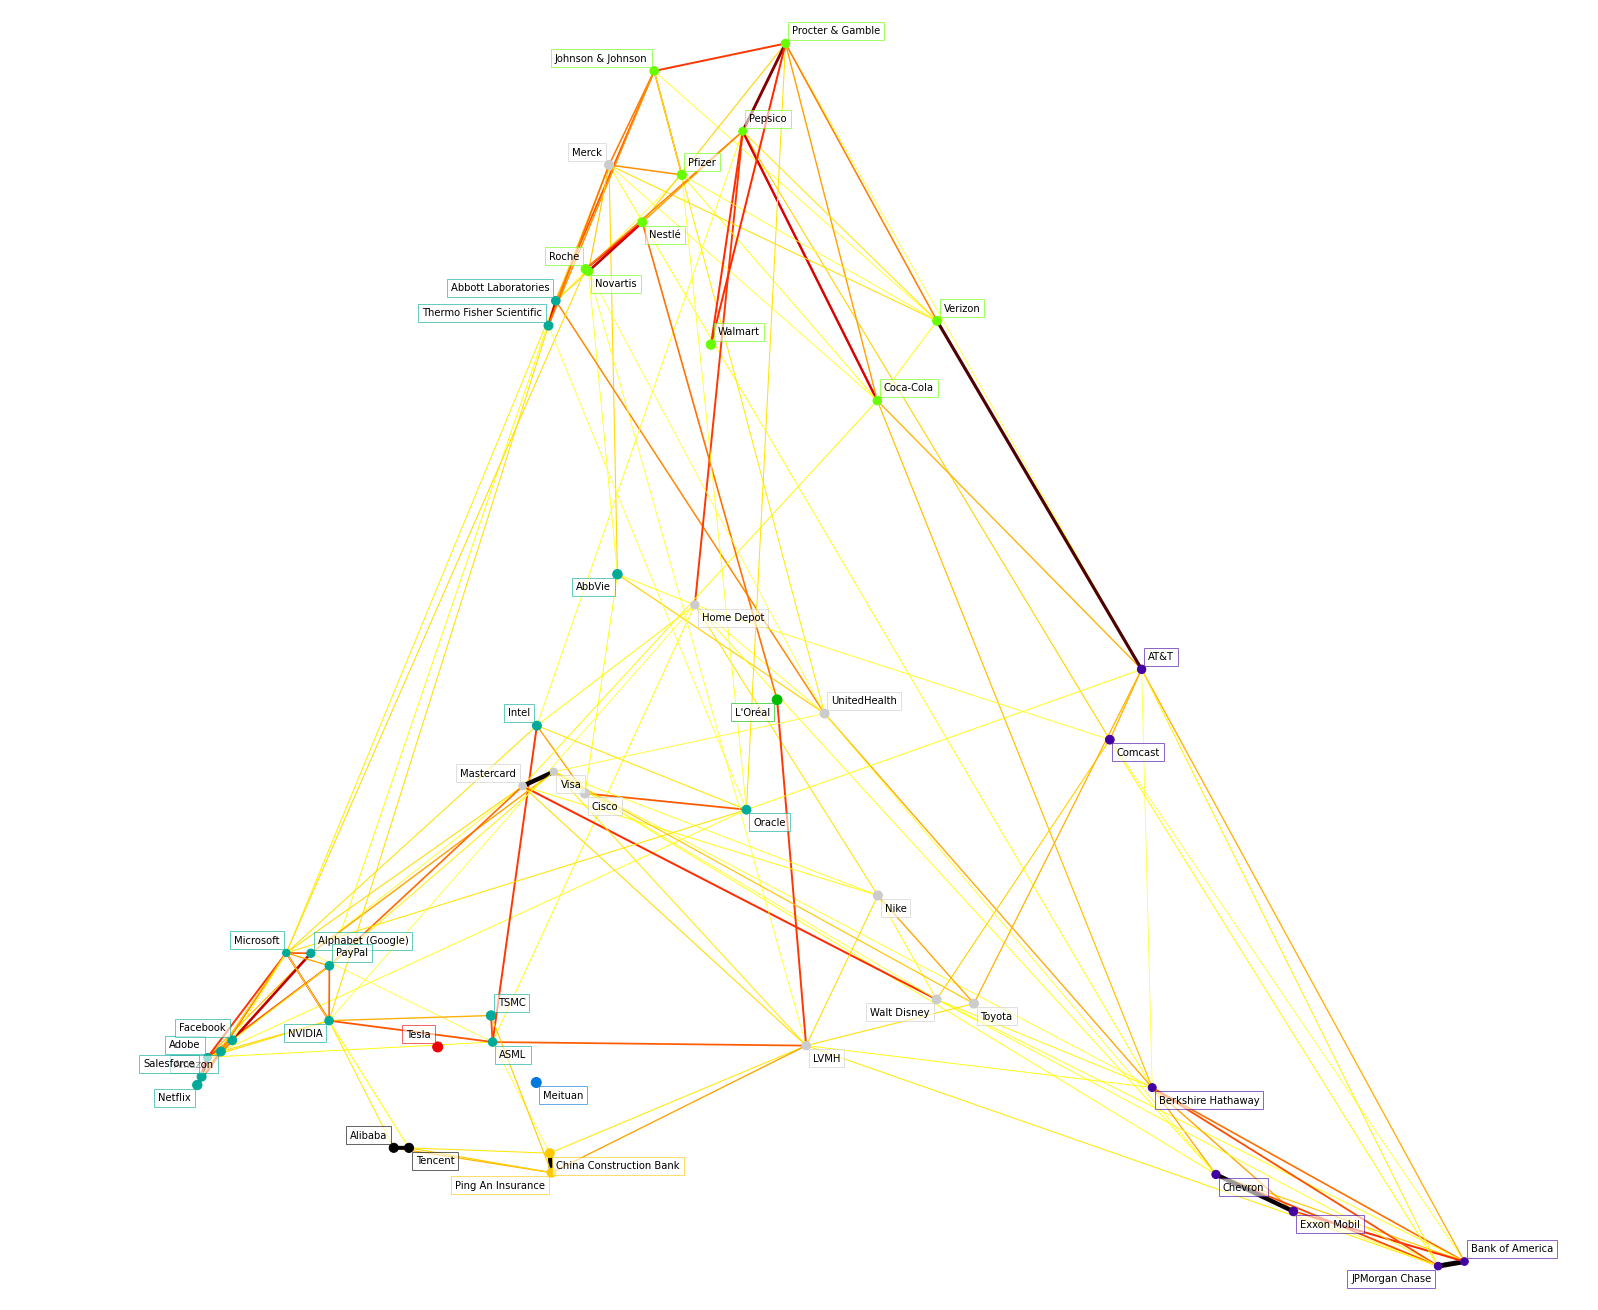

In [9]:
stock_cluster = manifoldAnalysis(stock_filter,comDic)

图表反应了变量之间的条件关系，而聚类反映了边际所属性：聚在一起的变量可以被认为在整个股票市场水平上具有类似的影响。
从图中可以看出，无监督学习通过对每日增幅信息的提取，可以大致勾勒出50支股票的一个市场结构，具有相同行业属性或概念属性的个股其波动表现出相似性，如科技，银行等。

###  2年来Max Return （%） for each stock

In [10]:
def stockExplore():
    stocks = pd.DataFrame()
    for file in glob.glob(os.getcwd()+'/train/'+"*.csv"):        
        stock = pd.read_csv(file)
        stock.drop(columns=['6. volume','7. dividend amount','8. split coefficient'],inplace = True)
        stocks = pd.concat([stocks,stock])
    return stocks

In [11]:
stocks = stockExplore()
stocks

date  1. open  2. high    3. low  4. close  5. adjusted close  \
0    2020-10-12   120.06   125.18  119.2845    124.40         123.999636   
1    2020-10-09   115.28   117.00  114.9200    116.97         116.593548   
2    2020-10-08   116.25   116.40  114.5901    114.97         114.599985   
3    2020-10-07   114.62   115.55  114.1300    115.08         114.709631   
4    2020-10-06   115.70   116.12  112.2500    113.16         112.795810   
..          ...      ...      ...       ...       ...                ...   
368  2019-04-29    80.12    80.38   79.6600     79.97          70.237169   
369  2019-04-26    80.27    80.63   79.5600     80.49          70.693882   
370  2019-04-25    81.65    82.84   81.4000     82.22          72.213330   
371  2019-04-24    83.01    83.08   81.7300     81.76          71.809315   
372  2019-04-23    83.19    83.49   82.6800     83.38          73.232151   

    stock symbol  change  pct_change (%)  MA5_close  MA5_open  MA30_close  \
0           AAPL    7.43           6.352    121.284   121.266  117.014333   
1           AAPL    2.00           1.740    120.874   120.066  117.002000   
2           AAPL   -0.11          -0.096    119.726   119.572  116.879667   
3           AAPL    1.92           1.697    118.504   118.296  116.781333   
4           AAPL   -3.34          -2.867    116.916   116.382  116.573667   
..           ...     ...             ...        ...       ...         ...   
368          XOM   -0.52          -0.646     78.736    79.300   75.440667   
369          XOM   -1.73          -2.104     79.340    79.796   75.626667   
370          XOM    0.46           0.563     80.326    80.470   75.881333   
371          XOM   -1.62          -1.943     80.944    81.084   76.129667   
372          XOM    0.48           0.579     81.564    81.648   76.476333   

      MA30_open  
0    117.192333  
1    117.080333  
2    117.035667  
3    116.902667  
4    116.774333  
..          ...  
368   75.519000  
369   75.688333  
370   75.926333  
371   76.236333  
372   76.554667  

[19026 rows x 13 columns]

In [12]:
def performance(df):
    new_df = df[['date', 'stock symbol', '4. close']].copy()
    new_df['date'] = pd.to_datetime(new_df['date'])
    new_df = new_df.pivot(index='date',columns='stock symbol')
    
    cum_ret = new_df.groupby(pd.Grouper(freq="Y")).apply(lambda x:(((x/x.shift(1)-1).fillna(0)+1.0).cumprod().round(3)))
    total_ret = (cum_ret.iloc[-1]-1).sort_values(ascending=False)
    annual_ret = total_ret.apply(lambda x:pow(1+x,1/15)-1)
    dd = (cum_ret.cummax()-cum_ret)/cum_ret.cummax()
    d = dd.max()
    ex_return = new_df.apply(lambda x:(x/x.shift(1)-1).fillna(0)-0.03/250)
    sharper_ratio = np.sqrt(len(ex_return))*ex_return.mean()/ex_return.std()
    perf_df = pd.DataFrame()
    
    perf_df['max return (%)']=round(d*100,3)
    perf_df['annual return (%)'] = round(annual_ret*100,3)
    perf_df['total return']= round(total_ret,3)
    perf_df['sharper ratio'] = round(sharper_ratio,3)
        
    index = perf_df.index.tolist()
 
    symbol_names = [x[1] for x in index]
    newDic = {}
    for i in range(len(symbol_names)):
        if symbol_names[i] in comDic:
            newDic[(index[i],symbol_names[i])] = comDic[symbol_names[i]]
    
    perf_df['company'] = [y for y in newDic.values()]
    
    perf_df.set_index('company',inplace=True)
    
    perf_df = perf_df.sort_values('max return (%)',ascending=False)
    
    fig = go.Figure()
    fig.add_trace(go.Bar(x=perf_df.index,y=perf_df['max return (%)'],marker=dict(color='#A2D5F2')))
    fig.update_layout(title=go.layout.Title(text='Max Return % Over the Past 2 Years', font=dict(family="Courier New, monospace",size=22,color="#000000")))
    fig.show()
    
    return perf_df

In [13]:
perf_df = performance(stocks)
perf_df

max return (%)  annual return (%)  total return  \
company                                                                     
Tesla                             81.820             -0.033        -0.005   
Apple                             77.345             -5.226        -0.553   
Meituan                           58.921              6.336         1.513   
Bank of America                   56.705             -2.257        -0.290   
Chevron                           56.208             -3.074        -0.374   
ASML                              54.980              2.200         0.386   
Exxon Mobil                       54.400             -4.567        -0.504   
JPMorgan Chase                    54.123             -2.340        -0.299   
UnitedHealth                      50.716              0.576         0.090   
Walt Disney                       49.348             -1.477        -0.200   
Nike                              46.888              1.362         0.225   
Mastercard                        45.418              0.871         0.139   
TSMC                              45.022              2.717         0.495   
AT&T                              44.724             -2.462        -0.312   
LVMH                              43.552              0.533         0.083   
Merck                             42.259             -0.804        -0.114   
Home Depot                        42.008              1.759         0.299   
Novartis                          41.898             -0.533        -0.077   
Coca-Cola                         41.252             -0.511        -0.074   
AbbVie                            40.850              0.152         0.023   
Visa                              40.596              0.396         0.061   
Facebook                          39.684              1.914         0.329   
Thermo Fisher Scientific          39.664              2.423         0.432   
NVIDIA                            39.412              6.291         1.497   
Abbott Laboratories               39.193              1.832         0.313   
Comcast                           36.828             -0.107        -0.016   
Salesforce                        35.689              3.268         0.620   
Procter & Gamble                  35.531              1.234         0.202   
Microsoft                         35.389              2.423         0.432   
Pfizer                            35.013             -0.265        -0.039   
Berkshire Hathaway                34.779             -0.634        -0.091   
Toyota                            34.263             -0.871        -0.123   
Roche                             33.853              0.414         0.064   
Intel                             33.755             -0.700        -0.100   
Oracle                            33.544              0.812         0.129   
Cisco                             33.012             -1.093        -0.152   
China Construction Bank           33.010             -2.032        -0.265   
Netflix                           32.738              3.357         0.641   
Nestlé                            31.951              0.674         0.106   
Pepsico                           31.462              0.508         0.079   
Alibaba                           31.145              2.096         0.365   
PayPal                            31.139              4.542         0.947   
Alphabet (Google)                 30.790              0.989         0.159   
L'Oréal                           29.317              0.871         0.139   
Johnson & Johnson                 28.478              0.262         0.040   
Adobe                             28.199              3.311         0.630   
Walmart                           27.126              1.412         0.234   
Ping An Insurance                 25.749             -1.101        -0.153   
Verizon                           24.611             -0.141        -0.021   
Amazon                            23.173              3.849         0.762   
Tencent               

### Comment

从图表中可以看出来，在过去的两年里，在max return 排名前十的股票中，其中属于cluster 2 的股票占比例最多

改一下##########################################

查看年化收益率排名前十的个股情况，Chevron Corporation十年来累计收益率为0.317%，年化收益1.853%，最大回撤63.3%，夏普比率为0.346，作为“买入持有策略”当之无愧的王者，当然排在第二的intel似乎知名度更高。其他上榜的个股年化超过25%，夏普比率大于2.5，但最大回撤均接近或超过60%，金证股份更高达90%。

所以我们对cluster 4 的几支股票进行分析

In [14]:
stock_cluster4 = stock_cluster[3]
stock_cluster4_names = stock_cluster4[1]
stock_cluster4_symbols = stock_cluster4[0]

In [15]:
stock_cluster4_names

array(['AbbVie', 'Abbott Laboratories', 'Adobe', 'Amazon', 'ASML',
       'Salesforce', 'Facebook', 'Alphabet (Google)', 'Intel',
       'Microsoft', 'Netflix', 'NVIDIA', 'Oracle', 'PayPal',
       'Thermo Fisher Scientific', 'TSMC'], dtype='<U24')

In [16]:
stock_cluster4_symbols

array(['ABBV', 'ABT', 'ADBE', 'AMZN', 'ASML', 'CRM', 'FB', 'GOOG', 'INTC',
       'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL', 'TMO', 'TSM'], dtype='<U24')

## 2年来市场整体的涨跌收益情况分析

In [17]:
def plot_data(df,condition,title):
    newDF = df[condition]
    newDF.index = pd.to_datetime(newDF['date'])
    count = newDF.groupby(by=newDF.index.month)['stock symbol'].nunique()
    countGP = newDF.groupby(by=newDF.index.month)['stock symbol'].unique()
    
    new_list=[]
    
    for row in countGP:
        row_list = row.tolist()
        for i in range(len(row_list)):
            if row_list[i] in comDic:
                row_list[i] = comDic[row_list[i]]
        new_list.append(row_list)  
    
    count_df = pd.DataFrame({'month':count.index, 'count_stock':count.values,'companies':new_list})

    fig = go.Figure()
    fig.add_trace(go.Bar(x=count_df.month,y=count_df.count_stock,marker=dict(color='#A2D5F2')))

    fig.update_layout(title=title,xaxis_title="month",yaxis_title="count",
                      font=dict(family="Courier New, monospace",size=22,color="#000000"))
    fig.show()
    return count_df

In [18]:
pct_change_10_p = plot_data(stocks,stocks['pct_change (%)']>10,'2年以来股价涨幅超过10%个股时间分布')
pct_change_10_p

month  count_stock                                          companies
0      1            1                                            [Tesla]
1      2            1                                            [Tesla]
2      3           31  [Apple, Abbott Laboratories, Adobe, ASML, Bank...
3      4            8  [ASML, Chevron, Mastercard, NVIDIA, PayPal, Te...
4      5            2                                  [Meituan, PayPal]
5      7            4            [Apple, Alphabet (Google), Tesla, TSMC]
6      8            3                       [Salesforce, Netflix, Tesla]
7      9            1                                            [Tesla]
8     10            1                                            [Tesla]

In [19]:
pct_change_10_n = plot_data(stocks,stocks['pct_change (%)']<-10,'2年以来股价日跌幅超过-10%个股时间分布')
pct_change_10_n

month  count_stock                                          companies
0      2            1                                            [Tesla]
1      3           29  [Apple, AbbVie, Adobe, ASML, Bank of America, ...
2      5            2                                   [Meituan, Tesla]
3      6            2                          [AbbVie, Bank of America]
4      7            3                            [Intel, Netflix, Tesla]
5      8            3                              [Apple, Cisco, Tesla]
6      9            1                                            [Tesla]

从涨幅和跌幅可以看出来，cluster 4的股票涨幅情况较好。

这两年来，每年的3月是股票的涨跌幅高峰期。



###  2年来cumulative return排名最前的10支股票

In [20]:
def top10_cum_return(df):
    new_df = df[['date', 'stock symbol', '4. close']].copy()
    new_df = new_df.pivot(index='date',columns='stock symbol')
    new_df.dropna(inplace=True)
    
    top10 = ((new_df.iloc[-1] - new_df.iloc[0]) / new_df.iloc[0]).dropna().sort_values(ascending=False)[:10]

    index = top10.index.tolist()

    newDic = {}
    index_names = [x[1] for x in index]

    for i in range(len(index_names)):
        if index_names[i] in comDic:
            newDic[index_names[i]] = comDic[index_names[i]]
        
    top10 = pd.DataFrame({'stock symbol':[key for key in newDic.keys()],'company':[x for x in newDic.values()],'cumulative_return':top10.values})
    
    fig = go.Figure()
    fig.add_trace(go.Bar(x=top10.company,y=top10.cumulative_return,marker=dict(color='#A2D5F2')))
    fig.update_layout(title=go.layout.Title(text="2年来收益率排名最前的10支股票", font=dict(family="Courier New, monospace",size=22,color="#000000")))
    fig.show() 
    
    return top10

In [21]:
top10 = top10_cum_return(stocks)
top10

stock symbol                   company  cumulative_return
0        MPNGF                   Meituan           4.018182
1         NVDA                    NVIDIA           1.976618
2          TSM                      TSMC           1.001982
3         ASML                      ASML           0.942651
4         PYPL                    PayPal           0.879407
5         ADBE                     Adobe           0.854747
6         AMZN                    Amazon           0.810401
7          TMO  Thermo Fisher Scientific           0.784371
8         MSFT                 Microsoft           0.771058
9         TSLA                     Tesla           0.709967

收益率排名前十的股票中，有40%都属于cluster 4 ，科技股

那我们看一下cluster 2 中 股票的 k line plot趋势

### cluster 2 中 股票的 k line plot

In [22]:
import matplotlib
from mplfinance.original_flavor import candlestick2_ohlc
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates

def draw_kline(stock_symbol,title):
    
    for file in glob.glob(os.getcwd()+'/train/'+"*.csv"): 
        if stock_symbol in file:
            df = pd.read_csv(file)
            break   
    
    df.sort_values(by=['date'],inplace=True)
    
    matplotlib.style.use('ggplot')
    
    fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=200)
    candlestick2_ohlc(ax,opens = df['1. open'].values,highs = df['2. high'].values,
                lows = df[ '3. low'].values,
                closes = df['4. close'].values,
                  width=0.5, colorup="r",colordown="g")
    
    ax.set_facecolor("white")
    ax.set_title(title)
    
    plt.plot(df['MA5_close'].values, alpha = 0.5, label='MA5_close')
    plt.plot(df['MA30_close'].values, alpha = 0.5, label='MA30_close')
    
    ax.legend(facecolor='white', edgecolor='black', fontsize=6)

    plt.xticks(ticks =np.arange(0,len(df)), labels = df.date)
    plt.xticks(size=8)
    
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    plt.show()

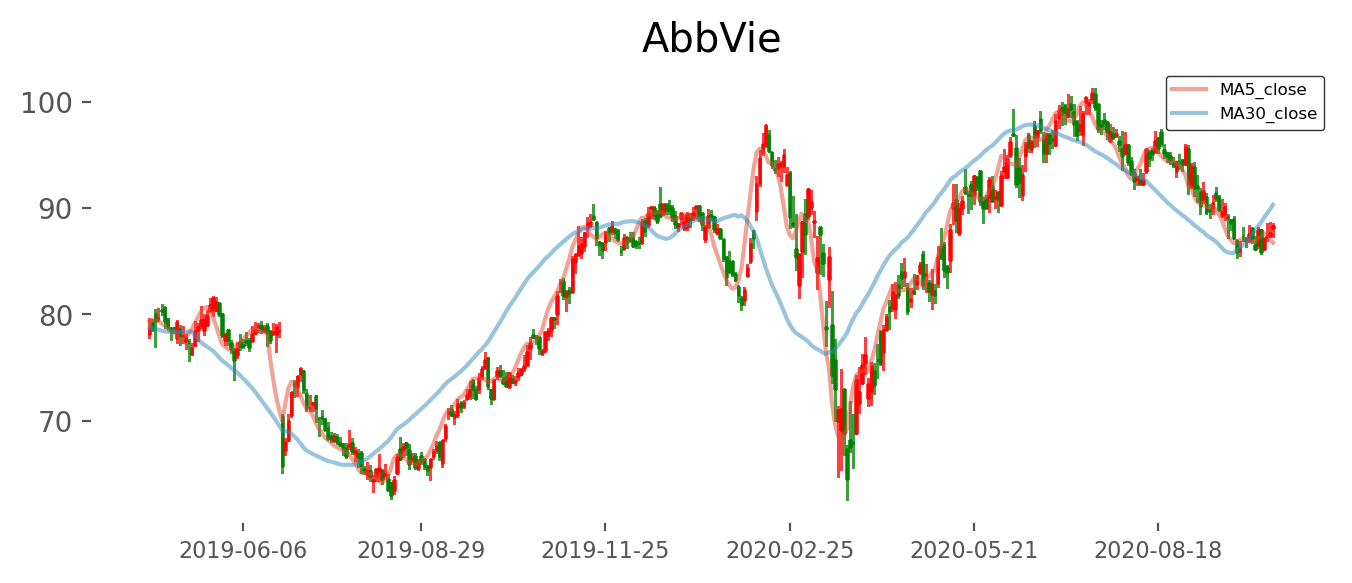

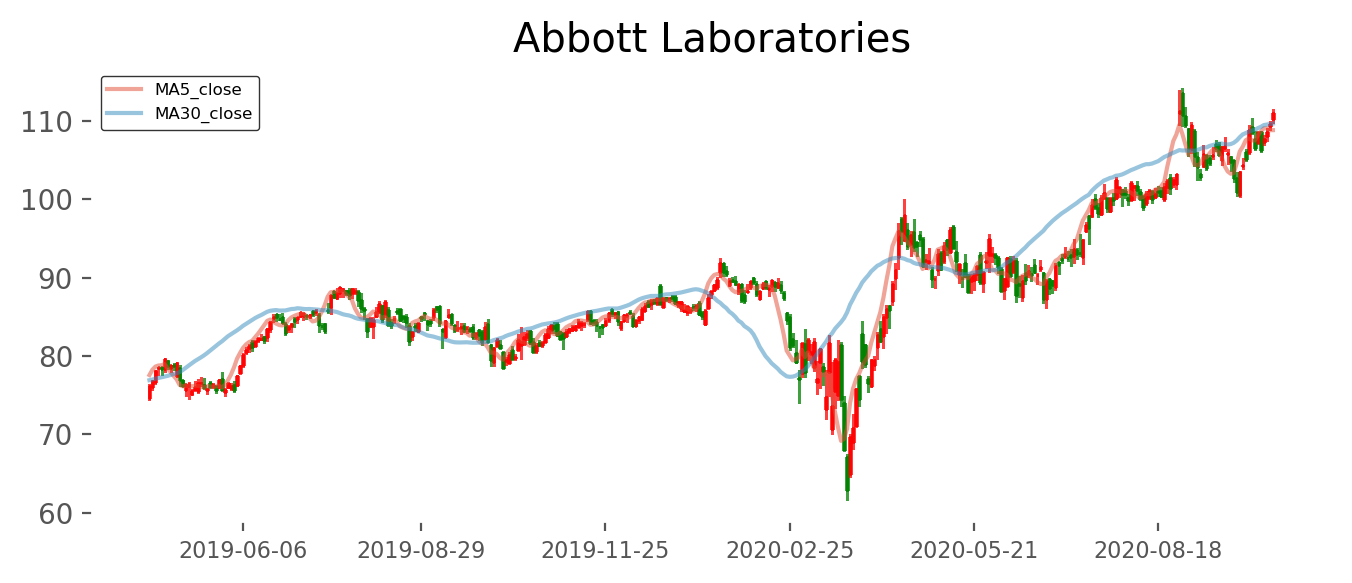

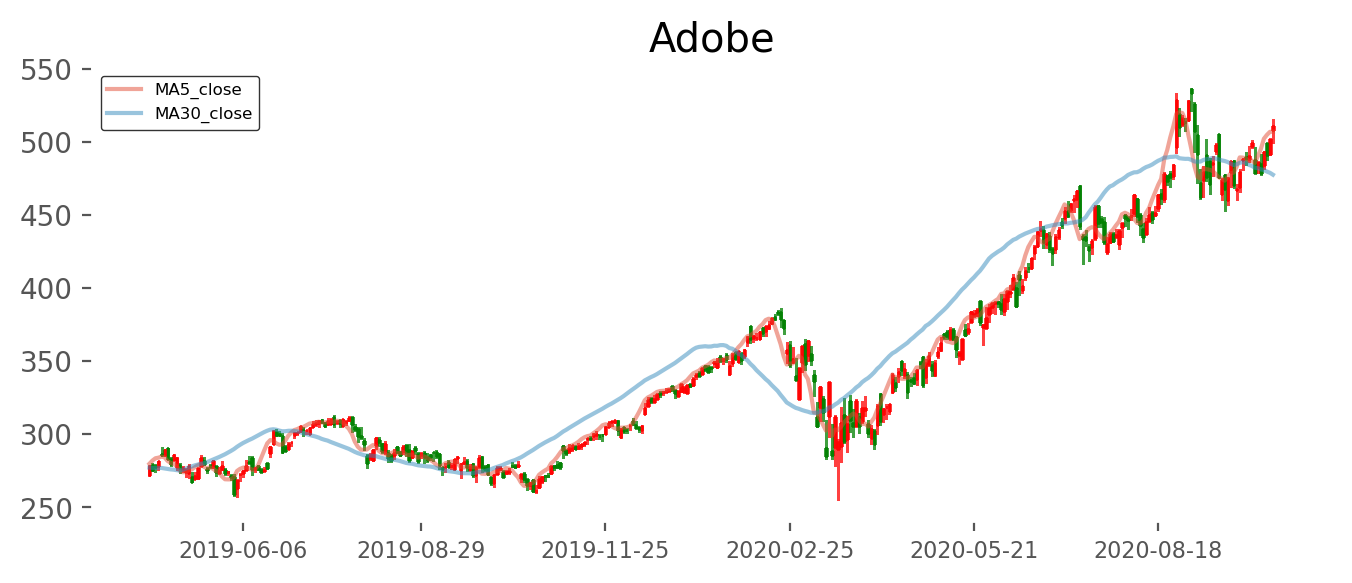

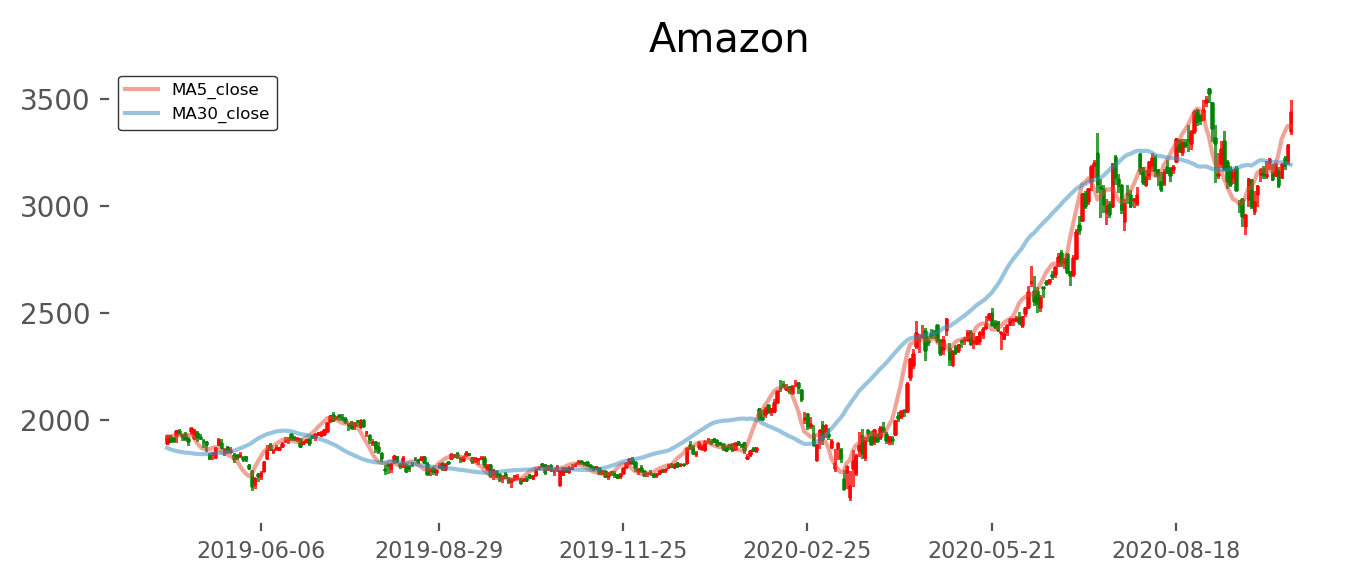

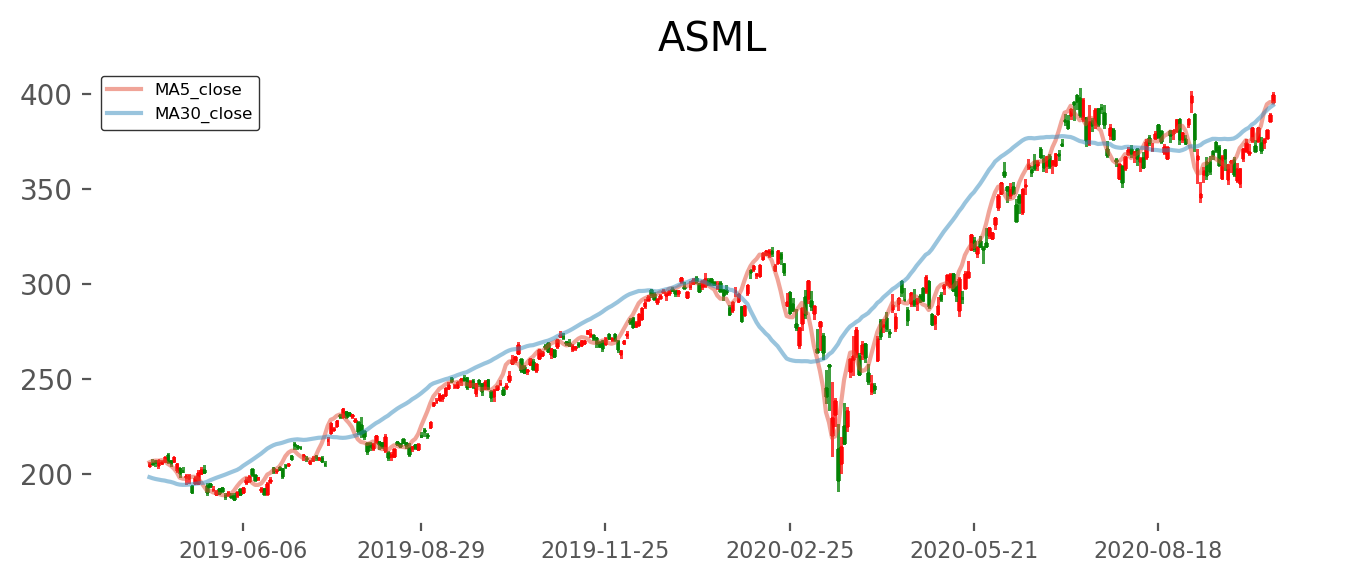

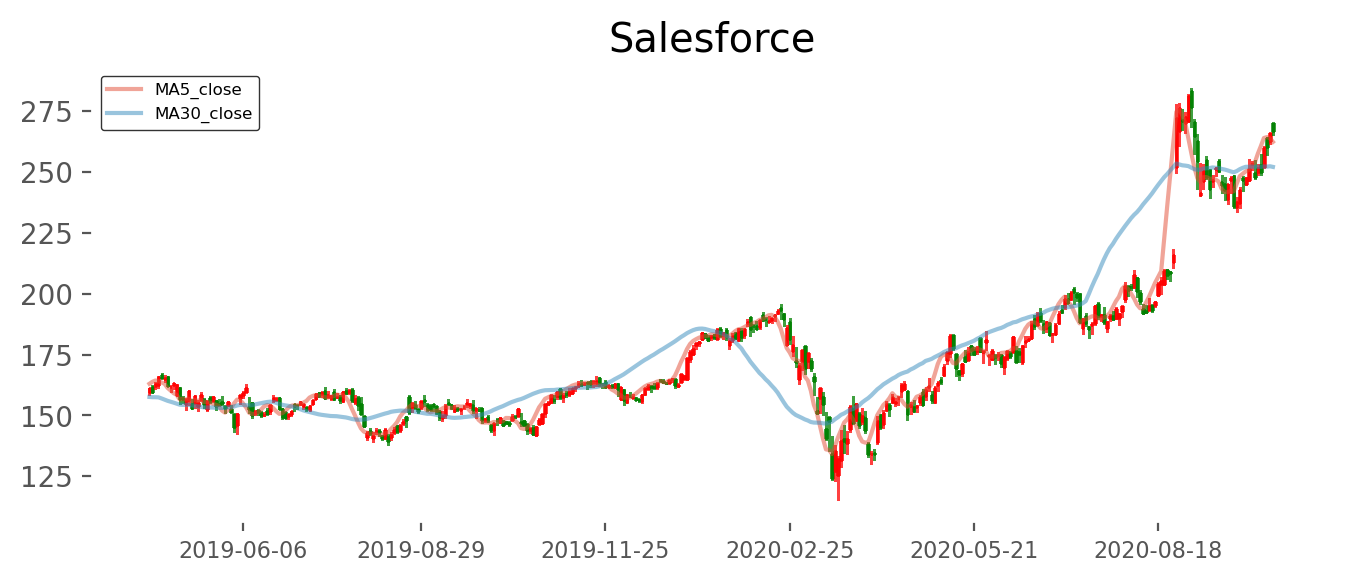

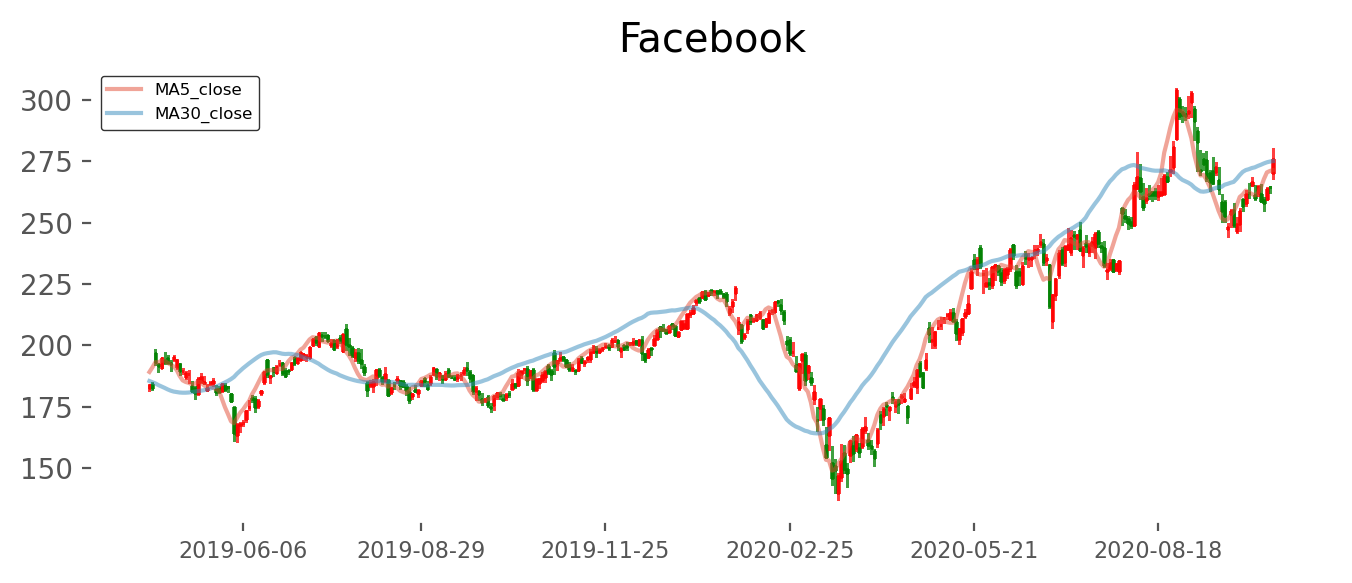

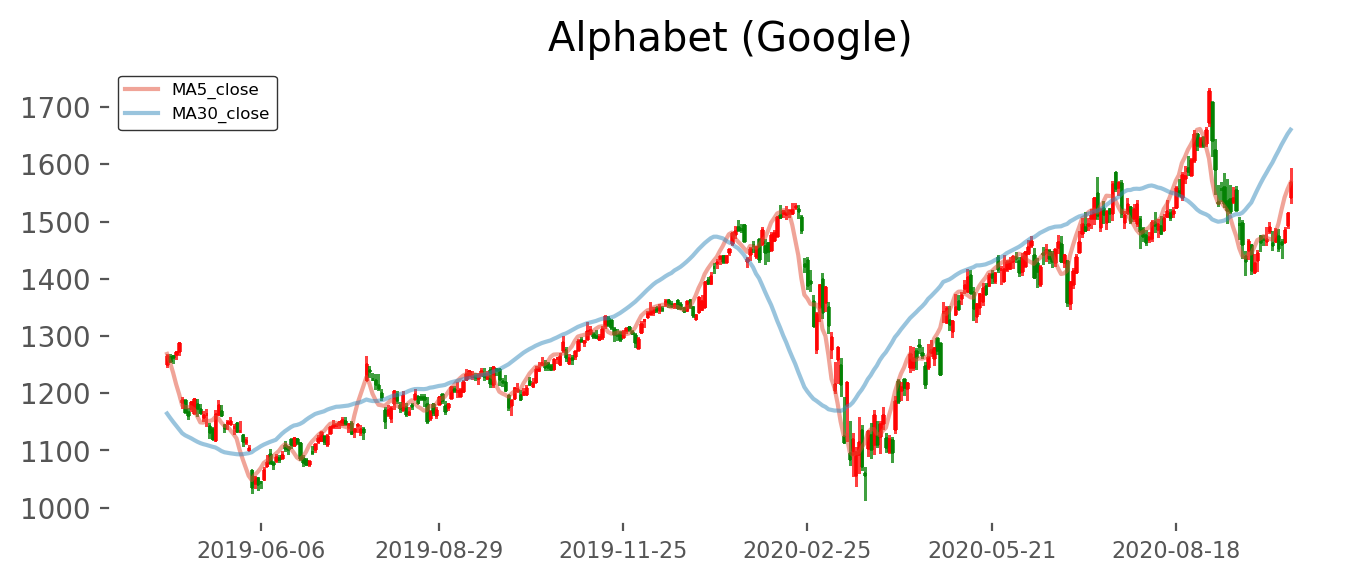

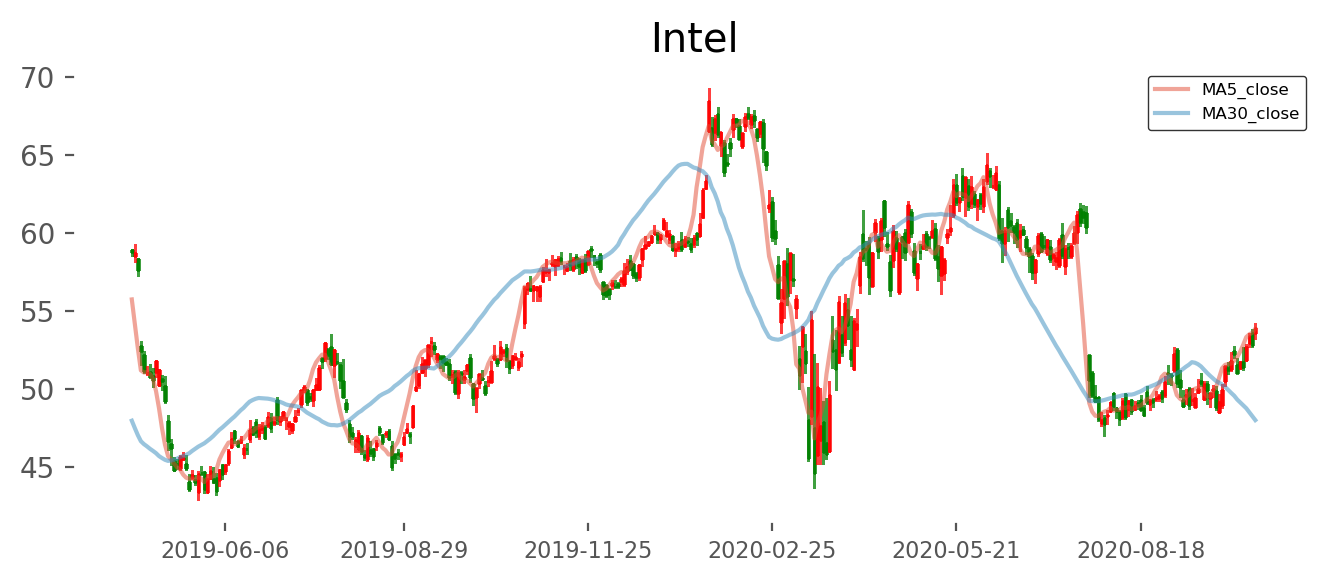

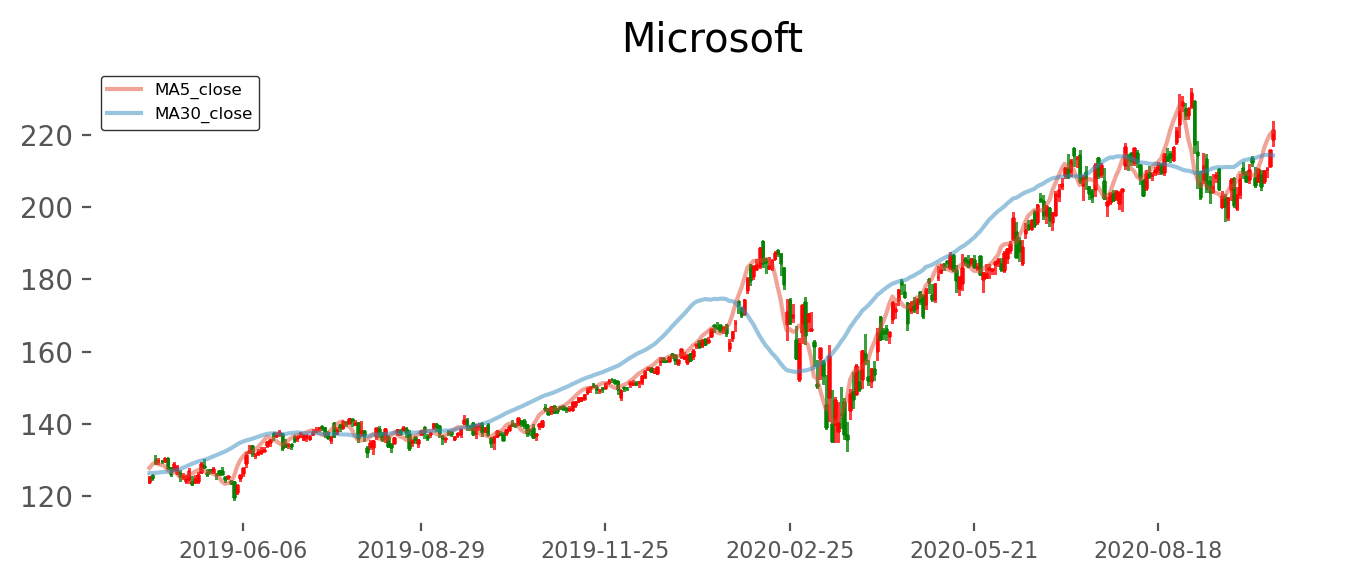

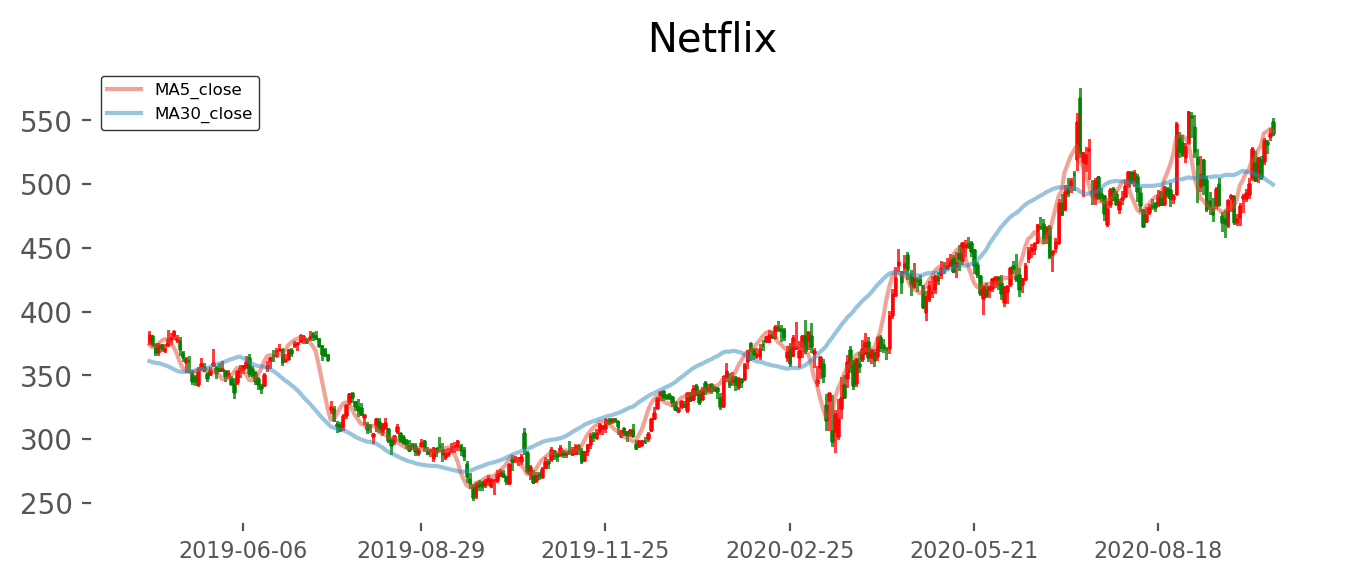

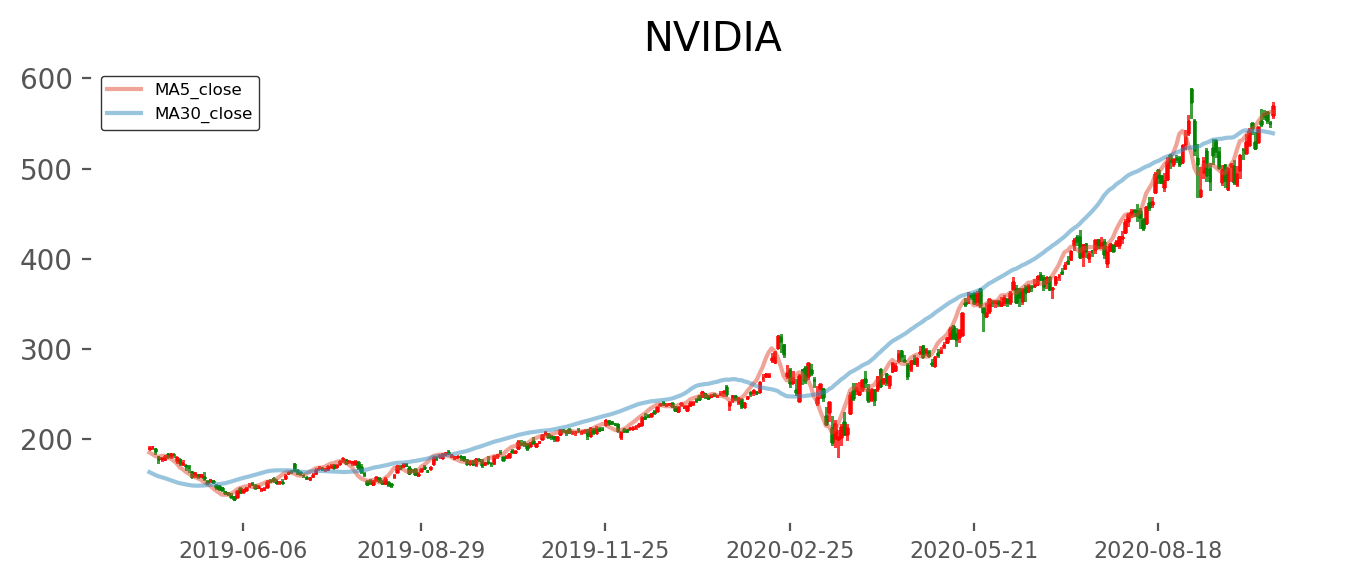

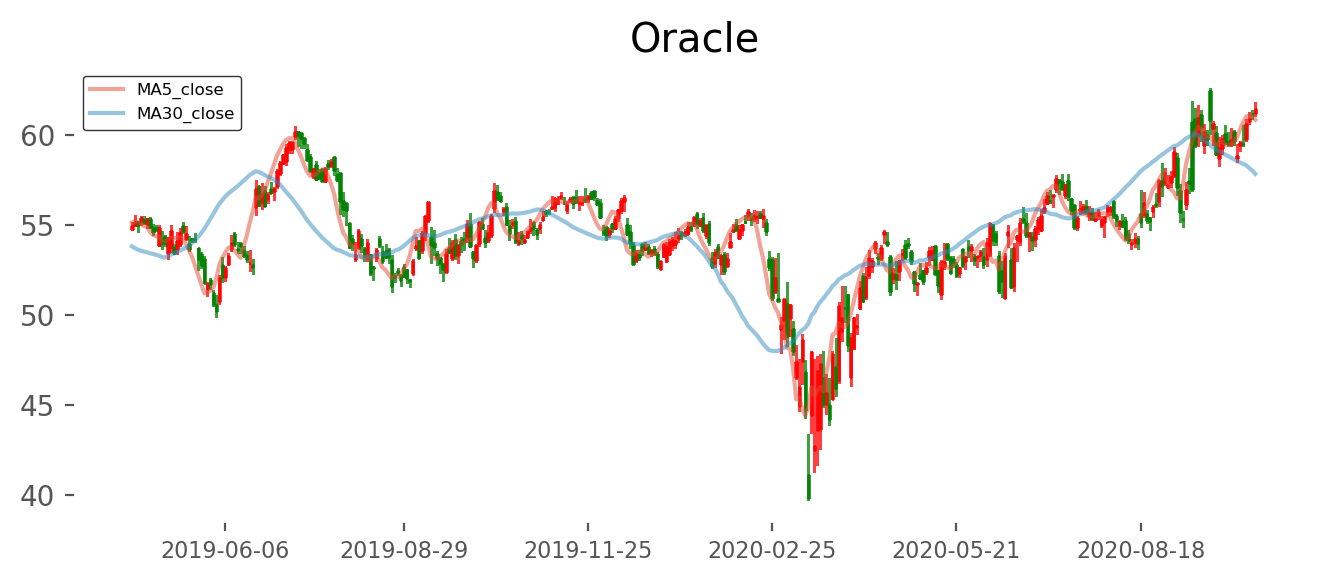

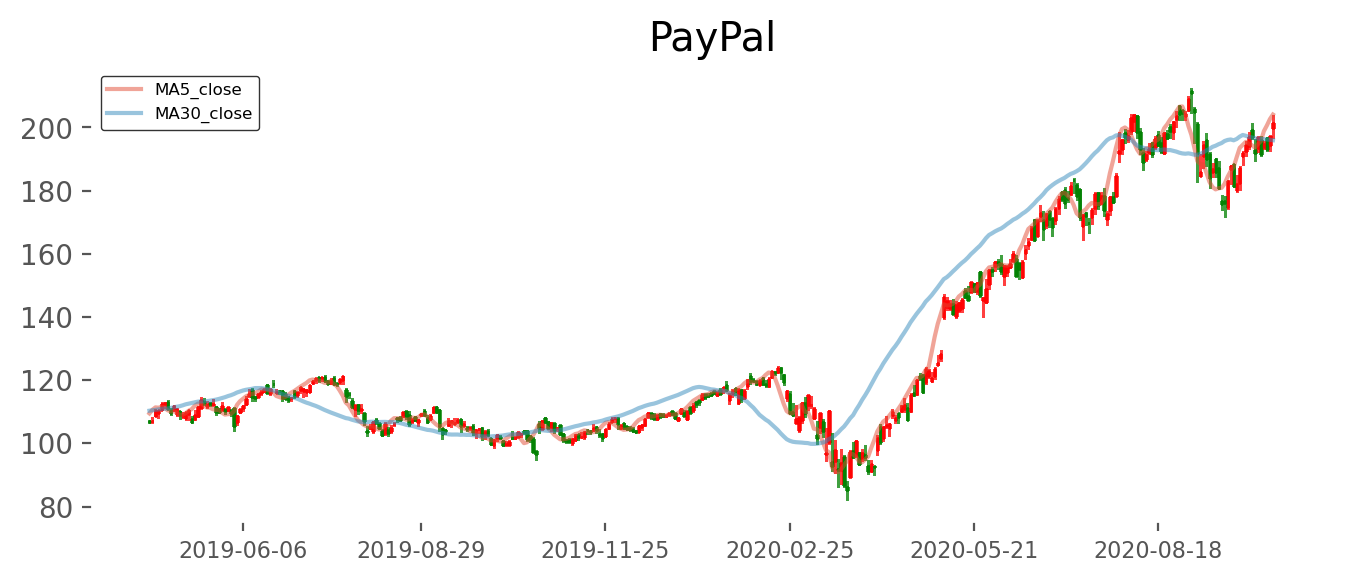

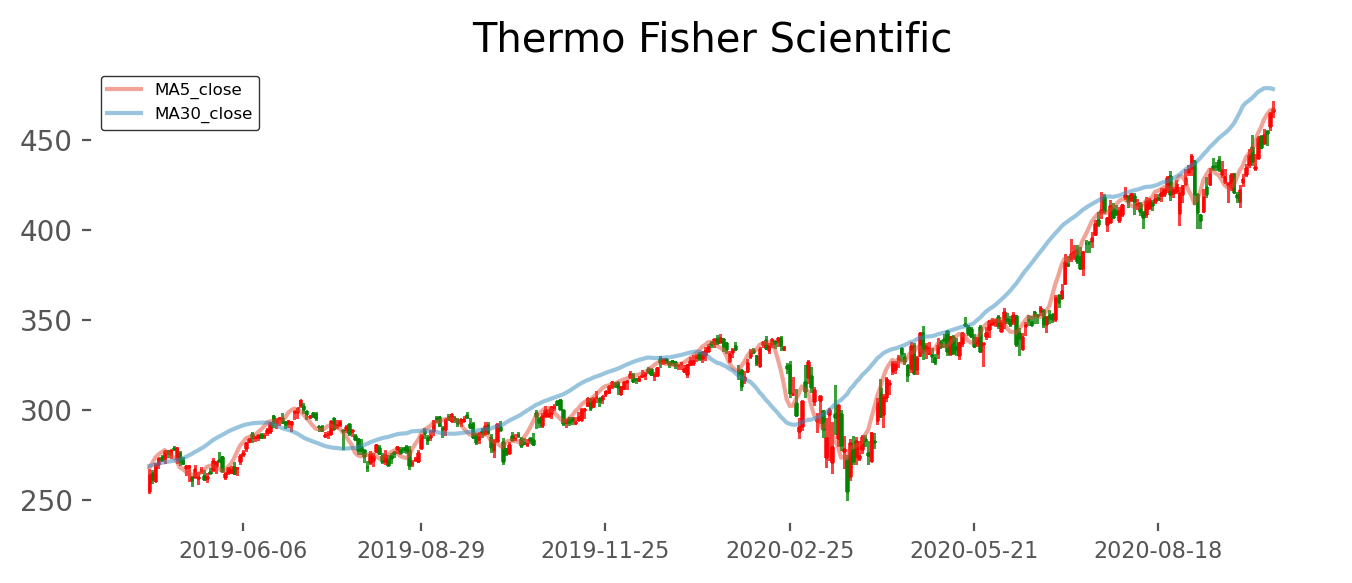

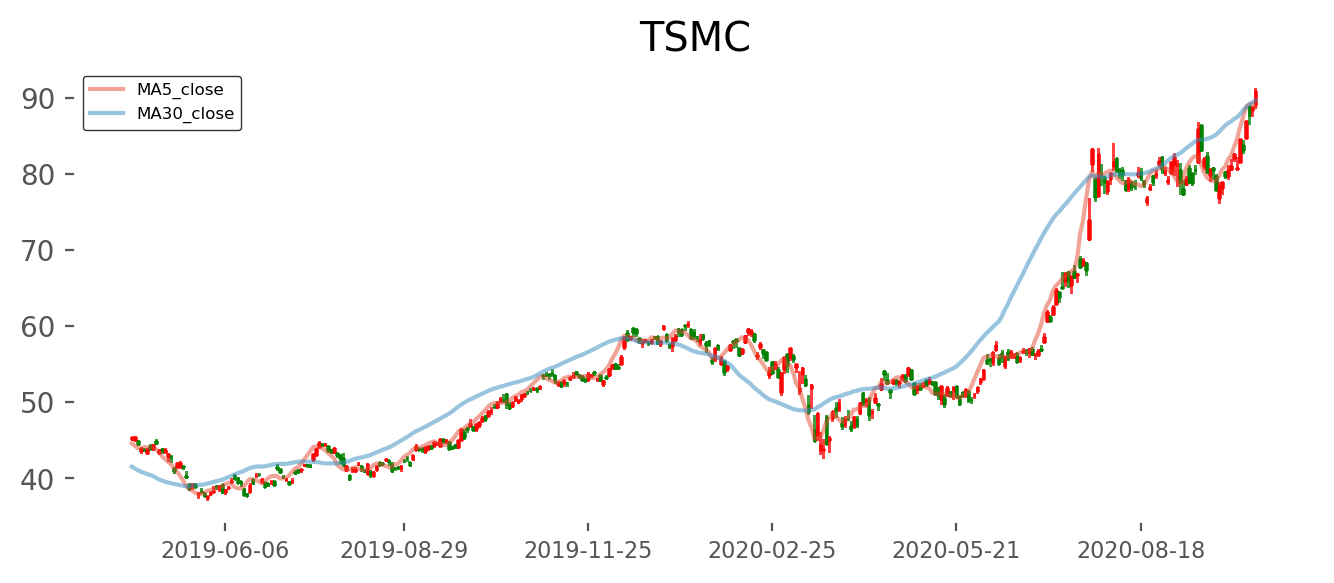

In [24]:
for i in range(len(stock_cluster4_symbols)):
    draw_kline(stock_cluster4_symbols[i],stock_cluster4_names[i])


5日均线是短线股民不可或缺的一部分参考指标，因此其也叫攻击线，如果5日均线上涨角度陡峭有力，则说明价格短线爆发力强。

1. 30日均线为主力庄家的护盘线,当股价向上突破30日均线时,一般会有主力资金进场了,一旦进入上升,只要回调不跌破30日均线,就说明主力资金尚未出局,上升并未结束,主力资金往往会在股价下跌时守护30日均线.当然,根据主力的操盘风格和习惯不同,会选择不同的25-35之间不同的中期均线来守护.

2. 股价上升回落至30日均线的时间至少应在1周以上,有可能股价横向整理并不出现大幅回落,等待30日均线上行来靠近股价,也有可能会出现大幅回落主动靠近30日均线.因此,对于买入时机的把握,应有耐心,并关注30日均线的支撑.

3. 当股价回落至30日均线附近,买入操作后,股价不升反跌,并有效跌破30日均线,尤其是放量破位时,应该坚决止损离场,哪怕等待股价重新回到30日均线之上时才买入.

4. 如果股价是缩量跌破30日均线,而30日均线仍保持上行,随后股价很快又回到其上方,说明还有上升的动力,可以考虑买入或继续持股.

### 综合来看，选取paypal, nvdia, salesforce,microsoft, facebook 五只股票进行投资组合，预测其投资组合的回报率

In [26]:
select_stocks_symbol = ['PYPL','NVDA','CRM','MSFT','FB']

#### 1. 用LSTM预测股票价格趋势

In [33]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers

#### Training data preparation

In [34]:
def data_train(stock_symbol):
    ts = TimeSeries(key='L6DM6V2VXBTDAMX9',output_format='pandas')
    try:
        data = ts.get_daily_adjusted(symbol=stock_symbol,outputsize='full')     
    except Exception as e:
        print('except: '+symbols[i])
        print('error: '+str(e))
        time.sleep(60)
        data = ts.get_daily_adjusted(symbol=stock_symbol,outputsize='full')
        
    data = pd.DataFrame(list(data)[0])
    stockSymbol = [stock_symbol]*len(data.index)
    intervalData = data.copy()
    intervalData.loc[:,'stock symbol'] = [stock_symbol]*len(intervalData.index)

    intervalData['change'] = intervalData['4. close'] - intervalData['4. close'].shift(-1)
    intervalData['pct_change'] = intervalData['4. close'].pct_change()

    #Moving Average
    intervalData['MA5_close'] = intervalData['4. close'].rolling(5).mean()
    intervalData['MA5_open'] = intervalData['1. open'].rolling(5).mean()

    intervalData['MA30_close'] = intervalData['4. close'].rolling(30).mean()
    intervalData['MA30_open'] = intervalData['1. open'].rolling(30).mean()


    intervalData = intervalData.dropna()
    intervalData.drop(columns=['7. dividend amount','8. split coefficient','stock symbol'],inplace = True)
    
    training_data = intervalData.copy()
    training_data = training_data[200:1200]
    training_data.sort_values(by=['date'],inplace=True)
    #print(training_data.head(5))
    
    #training features
    training_set = training_data.iloc[:, 1:12].values
        
    scaler = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = scaler.fit_transform(training_set)
    
    X_train = []
    y_train = []
    for i in range(60, len(training_data.index)):
        X_train.append(training_set_scaled[i-60:i, :])
        y_train.append(training_set_scaled[i, :])

    X_train, y_train = np.array(X_train), np.array(y_train)      
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 11))
    
    return X_train,y_train,intervalData,training_data,scaler #dataset,training_Data

#### Test data

In [35]:
def test_data(training_data,scaler,dataset,stock_symbol):
    
    test_dataset = dataset.head(200)
    test_dataset.sort_values(by=['date'],inplace=True)
    
    real_stock_price = test_dataset['4. close'].values
    
    dataset_total = pd.concat((training_data, test_dataset), axis = 0)
    db_all = dataset_total.iloc[:, 1:12].values

    inputs = db_all[len(dataset_total) - len(test_dataset) - 60:]
    inputs = inputs.reshape(-1,11)

    inputs = scaler.transform(inputs)
    X_test = []
    for i in range(60, 60+len(test_dataset.index)):
        X_test.append(inputs[i-60:i, :])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 11))
    
    return X_test,real_stock_price,test_dataset

#### 创建四个 LSTM 层 与一个全连接层的训练模型

In [36]:
def stock_model(X_train, y_train):
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 11)))
    
    model.add(Dropout(0.2))
    
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

    model.add(Dense(units = 11))
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    #model.fit(X_train, y_train, epochs = 200, batch_size = 32)
    model.fit(X_train, y_train, epochs = 2, batch_size = 32)
    
    return model

#### Prediction

In [37]:
def pred_price(X_train, y_train,train_data,dataset,scaler,symbol):
    model = stock_model(X_train, y_train)
    X_test,real_stock_price,test_dataset = test_data(train_data,scaler,dataset,symbol) #training_data,scaler,dataset,stock_symbol
    predicted_stock_price = model.predict(X_test)

    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

    return predicted_stock_price[:,0],real_stock_price,test_dataset

def plot_pred(predicted_stock_price,real_stock_price,symbol):
    plt.figure(figsize=(8, 3))
    plt.plot(real_stock_price, color = 'red', label = symbol+' Stock Price Trend')
    plt.plot(predicted_stock_price, color = 'green', label = 'Predicted '+symbol+' Stock Price Trend')
    plt.title(symbol+ ' Stock Price Trend Prediction For 200 days')
    plt.xlabel('Day')
    plt.ylabel(symbol+' Stock Price')
    plt.legend()
    plt.show()     
    
def run_pred(stock_symbols):
    pred_price_df = pd.DataFrame()

    for symbol in stock_symbols:
        X_train, y_train,dataset,training_data,scaler = data_train(symbol)
        predicted_stock_price,real_stock_price,test_dataset = pred_price(X_train, y_train,training_data,dataset,scaler,symbol)
        plot_pred(predicted_stock_price,real_stock_price,symbol)
        pred_price_df[symbol] = predicted_stock_price

    test_date = test_dataset.index

    pred_price_df['date'] = test_date
    pred_price_df.set_index('date',inplace=True)
    return pred_price_df,test_dataset
    

Epoch 1/2
30/30 [==============================] - 8s 62ms/step - loss: 0.0766
Epoch 2/2
30/30 [==============================] - 2s 64ms/step - loss: 0.0158


<ipython-input-35-dbbc747435ba>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



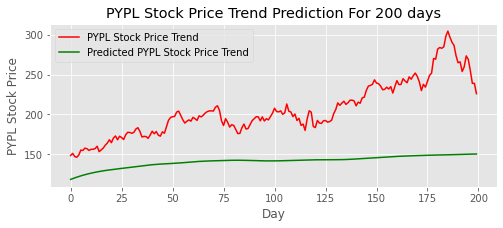

Epoch 1/2
30/30 [==============================] - 8s 62ms/step - loss: 0.0937
Epoch 2/2
30/30 [==============================] - 2s 63ms/step - loss: 0.0194


<ipython-input-35-dbbc747435ba>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



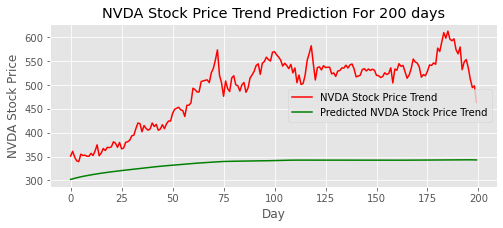

Epoch 1/2
30/30 [==============================] - 9s 62ms/step - loss: 0.1308
Epoch 2/2
30/30 [==============================] - 2s 59ms/step - loss: 0.0202


<ipython-input-35-dbbc747435ba>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



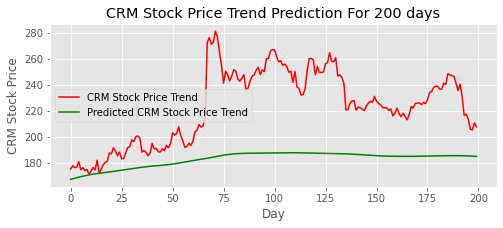

Epoch 1/2
30/30 [==============================] - 8s 61ms/step - loss: 0.1042
Epoch 2/2
30/30 [==============================] - 2s 62ms/step - loss: 0.0150


<ipython-input-35-dbbc747435ba>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



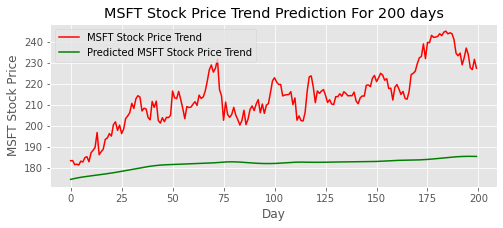

Epoch 1/2
30/30 [==============================] - 8s 62ms/step - loss: 0.1272
Epoch 2/2
30/30 [==============================] - 2s 63ms/step - loss: 0.0273


<ipython-input-35-dbbc747435ba>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



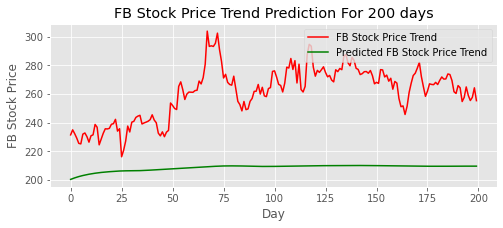

PYPL        NVDA         CRM        MSFT          FB
date                                                                  
2020-05-21  118.152382  302.143494  167.383408  174.572433  200.272873
2020-05-22  119.113380  303.313690  167.834579  174.801941  200.821701
2020-05-26  120.039726  304.463898  168.267700  175.014816  201.331833
2020-05-27  120.935066  305.557068  168.686020  175.212692  201.802689
2020-05-28  121.791718  306.578461  169.091370  175.395386  202.231827
...                ...         ...         ...         ...         ...
2021-03-02  149.931442  343.293365  185.399933  185.517258  209.524063
2021-03-03  149.974854  343.228790  185.322037  185.520935  209.522385
2021-03-04  150.016602  343.142609  185.234100  185.516724  209.520508
2021-03-05  150.054565  343.040161  185.138351  185.505493  209.520752
2021-03-08  150.078796  342.935516  185.035187  185.488831  209.522873

[200 rows x 5 columns]

In [38]:
pred_price_df ,test_dataset= run_pred(select_stocks_symbol)

pred_price_df

In [39]:
test_date = test_dataset.index
pred_price_df['date'] = test_date
pred_price_df.set_index('date',inplace=True)
pred_price_df.sort_index(ascending = False,inplace=True)
pred_price_df

PYPL        NVDA         CRM        MSFT          FB
date                                                                  
2021-03-08  150.078796  342.935516  185.035187  185.488831  209.522873
2021-03-05  150.054565  343.040161  185.138351  185.505493  209.520752
2021-03-04  150.016602  343.142609  185.234100  185.516724  209.520508
2021-03-03  149.974854  343.228790  185.322037  185.520935  209.522385
2021-03-02  149.931442  343.293365  185.399933  185.517258  209.524063
...                ...         ...         ...         ...         ...
2020-05-28  121.791718  306.578461  169.091370  175.395386  202.231827
2020-05-27  120.935066  305.557068  168.686020  175.212692  201.802689
2020-05-26  120.039726  304.463898  168.267700  175.014816  201.331833
2020-05-22  119.113380  303.313690  167.834579  174.801941  200.821701
2020-05-21  118.152382  302.143494  167.383408  174.572433  200.272873

[200 rows x 5 columns]

### Use Markowitz model for the optimized portfolio selection

In [40]:
def cal_weight(select_stock,select_stocks_symbol):
    
    number = 10000
    random_p = np.empty((number, 7))
    np.random.seed(100)
    
    cov_mat = select_stock.cov()
    cov_mat_annual = cov_mat * 252

    for i in range(number):
        random5 = np.random.random(5)
        random_weight = random5 / np.sum(random5)
        mean_return = select_stock.mul(random_weight, axis=1).sum(axis=1).mean()
        annual_return = (1 + mean_return)**252 - 1

        random_volatility = np.sqrt(np.dot(random_weight.T,np.dot(cov_mat_annual, random_weight)))

        random_p[i][:5] = random_weight
        random_p[i][5] = annual_return
        random_p[i][6] = random_volatility

    random_portfolios = pd.DataFrame(random_p)
    random_portfolios.columns = [ticker + "_weight" for ticker in select_stocks_symbol]  + ['returns', 'volatility']
    
    min_index = random_portfolios.volatility.idxmin()

    GMV_weights = np.array(random_portfolios.iloc[min_index, 0:5])

    return GMV_weights




In [41]:
new_df = stocks[['date', 'stock symbol', '4. close']].copy()
new_df = new_df.pivot(index='date',columns='stock symbol')
col_name = [i[1] for i in new_df.columns]

new_df.columns = col_name

stock_return = new_df.pct_change().dropna()

select_stock_df = stock_return[select_stocks_symbol].copy()
select_stock_df.dropna(inplace=True)
print(select_stock_df.head(5))

                PYPL      NVDA       CRM      MSFT        FB
date                                                        
2019-04-25  0.027980 -0.022284  0.022123  0.033117  0.058495
2019-04-26  0.003085 -0.047188  0.017598  0.005730 -0.009159
2019-04-29  0.017004  0.006963 -0.003615 -0.000924  0.017181
2019-04-30  0.002935  0.009312 -0.000060  0.006396 -0.007085
2019-05-01 -0.016228 -0.002928 -0.019353 -0.020827 -0.001913


## GMV weight for portfolio

In [42]:
GMV_weights = cal_weight(select_stock_df,select_stocks_symbol)
print(GMV_weights)

[0.01965079 0.00202012 0.07498191 0.44745744 0.45588975]


## Predicted portfolio return for recent 10 days

In [43]:
pred_price_df['portfolio_ret_pred'] = pred_price_df.mul(GMV_weights, axis=1).sum(axis=1)
pred_price_df.head(10)

PYPL        NVDA         CRM        MSFT          FB  \
date                                                                     
2021-03-08  150.078796  342.935516  185.035187  185.488831  209.522873   
2021-03-05  150.054565  343.040161  185.138351  185.505493  209.520752   
2021-03-04  150.016602  343.142609  185.234100  185.516724  209.520508   
2021-03-03  149.974854  343.228790  185.322037  185.520935  209.522385   
2021-03-02  149.931442  343.293365  185.399933  185.517258  209.524063   
2021-03-01  149.880722  343.339935  185.465683  185.506134  209.524445   
2021-02-26  149.811081  343.385376  185.522018  185.486633  209.526077   
2021-02-25  149.725540  343.432495  185.566330  185.457047  209.528458   
2021-02-24  149.634842  343.431091  185.596405  185.416946  209.527039   
2021-02-23  149.535416  343.429871  185.614487  185.366135  209.522263   

            portfolio_ret_pred  
date                            
2021-03-08          196.033920  
2021-03-05          196.047882  
2021-03-04          196.059418  
2021-03-03          196.068115  
2021-03-02          196.072357  
2021-03-01          196.071579  
2021-02-26          196.066544  
2021-02-25          196.056122  
2021-02-24          196.038010  
2021-02-23          196.012482

## Real portfolio return for recent 10 days

In [44]:
stock_test_dataset = pd.DataFrame()

for file in glob.glob(os.getcwd()+'/test/'+"*.csv"): 
    if file.split("\\")[-1].split('_')[0] in select_stocks_symbol:
        df = pd.read_csv(file)
        df['stock symbol'] = [file.split("\\")[-1].split('_')[0]]*len(df.index)
        stock_test_dataset = pd.concat([stock_test_dataset,df])

new_df = stock_test_dataset[['date','stock symbol', '4. close']].copy()

new_df = new_df.pivot(index='date',columns='stock symbol')
col_name = [i[1] for i in new_df.columns]

new_df.columns = col_name


new_df['portfolio_ret_real'] = new_df.mul(GMV_weights, axis=1).sum(axis=1)
new_df.sort_index(ascending=False,inplace=True)
new_df.head(10)

CRM       FB    MSFT    NVDA    PYPL  portfolio_ret_real
date                                                                   
2021-03-08  207.72  255.310  227.39  463.73  226.09          332.219304
2021-03-05  210.76  264.280  231.60  498.46  239.05          354.061365
2021-03-04  205.33  257.640  226.73  494.81  239.07          351.951984
2021-03-03  206.00  255.410  227.56  512.19  255.06          367.089368
2021-03-02  213.47  259.000  233.87  536.25  269.19          384.924095
2021-03-01  217.54  264.910  236.94  553.67  273.63          395.065066
2021-02-26  216.50  257.620  232.38  548.58  259.85          386.128266
2021-02-25  231.08  254.690  228.99  532.30  253.94          376.175752
2021-02-24  240.47  264.310  234.55  579.96  266.07          403.652369
2021-02-23  235.64  265.855  233.27  565.68  265.00          396.587106

## Real and predicted portfolio return comparison

In [45]:
portfo_ret_df = pd.DataFrame()
portfo_ret_df['date'] = pred_price_df.index.tolist()[:10]
portfo_ret_df['real'] = new_df['portfolio_ret_real'].tolist()[:10]
portfo_ret_df['predict'] = pred_price_df['portfolio_ret_pred'].tolist()[:10]
portfo_ret_df.set_index('date',inplace=True)
portfo_ret_df

real     predict
date                              
2021-03-08  332.219304  196.033920
2021-03-05  354.061365  196.047882
2021-03-04  351.951984  196.059418
2021-03-03  367.089368  196.068115
2021-03-02  384.924095  196.072357
2021-03-01  395.065066  196.071579
2021-02-26  386.128266  196.066544
2021-02-25  376.175752  196.056122
2021-02-24  403.652369  196.038010
2021-02-23  396.587106  196.012482